### Notebook for optimal initial sampling for material composition -> properties problem. 4 dimensions

written by Christina Schenk

last updated on 09/01/2025

tested on Christina's M1 Mac

#### import python packages

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
import lhsmdu
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../CASTRO/src")
from plot import *
from conditionedSampling import *
from utils import *

### Setting up a Single-Task GP Autonomous Data Acquisition Run

##### Specify the design space: lower and upper bounds for x and y, number of points at which we want to predict

In [2]:
#Lower and upper bounds for x and y:
#polymer:
PA56_lb = 0.8
PA56_ub = 1.0
#phytic acid:
PhA_lb = 0.0
PhA_ub = 0.05
#amino-based acids:
am_lb = 0.0
am_ub = 0.1
#metallic-based acids:
met_lb = 0.0
met_ub = 0.14


#dimension of design space:
dim = 4

#number of samples
n_samp = 170

x1_lb = PA56_lb
x1_ub = PA56_ub

x2_lb = PhA_lb
x2_ub = PhA_ub

x3_lb = am_lb
x3_ub = am_ub

x4_lb = met_lb
x4_ub = met_ub
bounds = [[x1_lb,x1_ub], [x2_lb,x2_ub], [x3_lb,x3_ub], [x4_lb,x4_ub]]

#### Latin Hypercube sampling on domain with variables summing up to 1: Sequentially and infeasible ones rejected/removed from sample set: 
to do: Still uniform?

In [3]:
import numpy as np
from scipy.stats import qmc

# Define the number of samples and the number of dimensions
n_samp = 90  # Adjust as needed
n_dim = 4      # 9 dimensions
seeds = [42, 123, 7, 99, 56]  # List of random seeds


# Function to normalize the samples
def normalize(samples):
    return samples / samples.sum(axis=1, keepdims=True)

# Function to scale the normalized samples while maintaining the sum constraint
def scale_and_renormalize(samples, bounds):
    scaled_samples = np.zeros_like(samples)
    for i, (lb, ub) in enumerate(bounds):
        scaled_samples[:, i] = lb + samples[:, i] * (ub - lb)
    # After scaling, renormalize to ensure the sum is exactly 1
    return scaled_samples / scaled_samples.sum(axis=1, keepdims=True)

# List to store the scaled samples from each seed
all_scaled_samples = []

# Generate samples for each seed
for seed in seeds:
    # Step 1: Create Latin Hypercube sampler with the current seed
    sampler = qmc.LatinHypercube(d=n_dim, seed=seed)
    
    # Step 2: Generate Latin Hypercube samples
    samples = sampler.random(n=n_samp)
    
    # Step 3: Normalize the samples
    samples_normalized = normalize(samples)
    
    # Step 4: Scale and renormalize the samples
    scaled_samples = scale_and_renormalize(samples_normalized, bounds)
    
    # Store the scaled samples
    all_scaled_samples.append(scaled_samples)

# Stack all the samples along a new axis (shape: num_seeds x n_samp x n_dim)
all_scaled_samples = np.stack(all_scaled_samples, axis=0)

# Compute the mean and standard deviation across the seeds (axis=0)
mean_samples = np.mean(all_scaled_samples, axis=0)
std_samples = np.std(all_scaled_samples, axis=0)

# Verify the shapes of the results
print(f"\nShape of mean samples: {mean_samples.shape}")
print(f"Shape of std samples: {std_samples.shape}")

# Print the mean and standard deviation of the first 5 samples
print("\nMean of the first 5 samples:")
print(mean_samples[:5])


Shape of mean samples: (90, 4)
Shape of std samples: (90, 4)

Mean of the first 5 samples:
[[0.90999    0.01290838 0.03260835 0.04449327]
 [0.91340834 0.01967252 0.02835502 0.03856412]
 [0.92885027 0.02260745 0.01119383 0.03734845]
 [0.92510028 0.01912222 0.02415241 0.03162509]
 [0.91842698 0.01517639 0.03424017 0.03215646]]


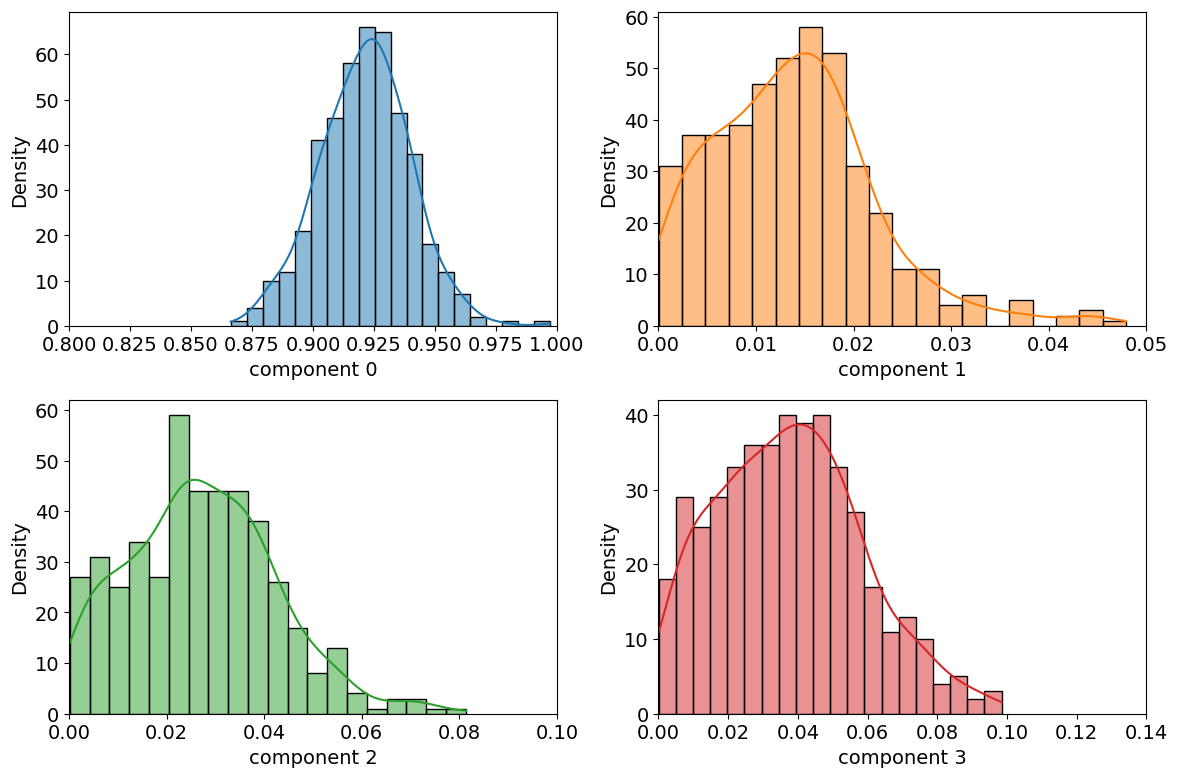

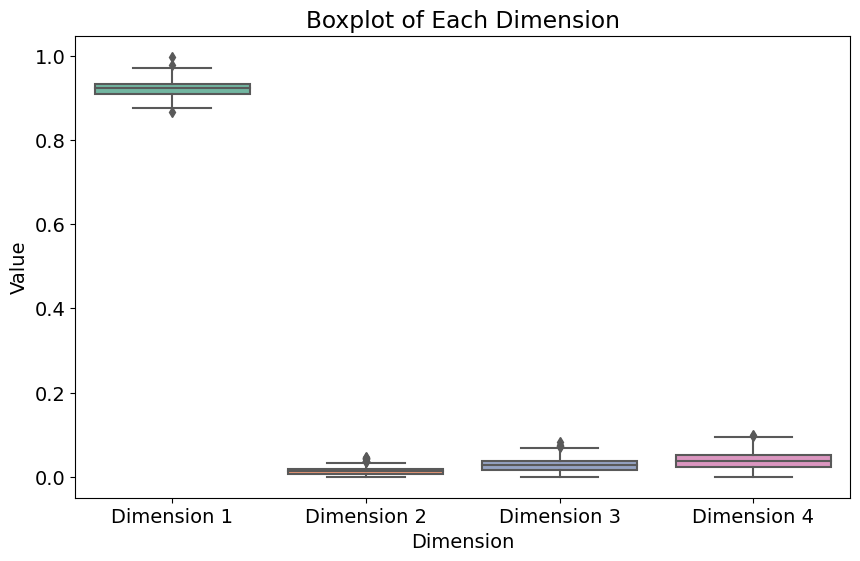

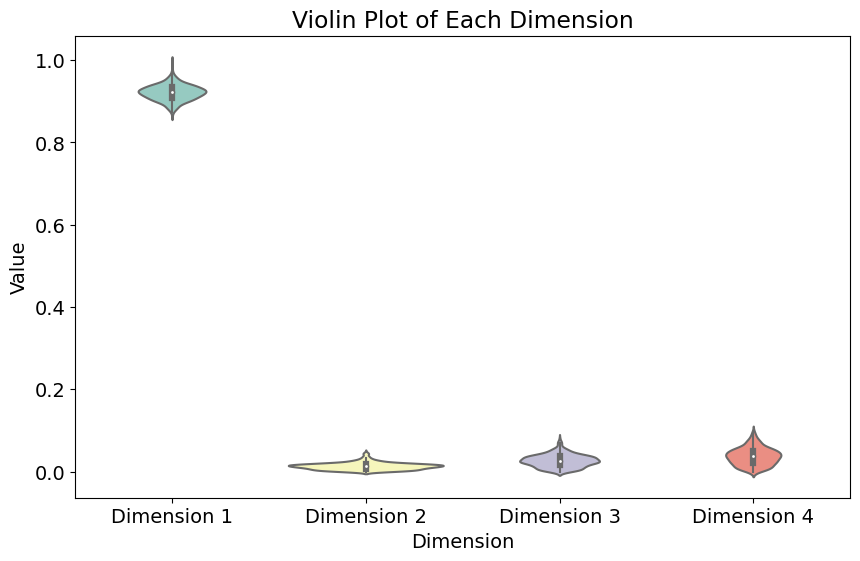

In [4]:
# Combine all samples into a single array (shape: num_seeds * n_samp, n_dim)
combined_samples = all_scaled_samples.reshape(-1, n_dim)

# Plot settings
#sns.set(style="whitegrid")
dim_labels = [f"Dimension {i+1}" for i in range(n_dim)]

# Plot 1: Histograms for each dimension
plt.figure(figsize=(12, 8))
for i in range(n_dim):
    ax = plt.subplot(2, 2, i + 1)
    sns.histplot(combined_samples[:, i], bins=20, kde=True, color=f"C{i}")
    #ax.set_title(f"Histogram of {dim_labels[i]}")
    ax.set_xlabel(f"component {i}")
    ax.set_ylabel("Density")
    if bounds is not None and i < len(bounds):
        ax.set_xlim(bounds[i])  # Correct way to set x-limits for each subplot
plt.tight_layout()
plt.show()


# Plot 2: Boxplot for each dimension
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_samples, palette="Set2")
plt.title("Boxplot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

# Plot 3: Violin Plot for Each Dimension
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_samples, palette="Set3")
plt.title("Violin Plot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

In [5]:
len(scaled_samples)
all_val_samples = mean_samples

In [6]:
all_val_samples

array([[0.90999   , 0.01290838, 0.03260835, 0.04449327],
       [0.91340834, 0.01967252, 0.02835502, 0.03856412],
       [0.92885027, 0.02260745, 0.01119383, 0.03734845],
       [0.92510028, 0.01912222, 0.02415241, 0.03162509],
       [0.91842698, 0.01517639, 0.03424017, 0.03215646],
       [0.95001341, 0.01346673, 0.01042114, 0.02609871],
       [0.91630739, 0.01618951, 0.03361773, 0.03388537],
       [0.91920083, 0.01792324, 0.03840842, 0.02446751],
       [0.91818681, 0.01211347, 0.03433674, 0.03536298],
       [0.93050636, 0.00851679, 0.03575736, 0.0252195 ],
       [0.91684756, 0.0100445 , 0.02743427, 0.04567368],
       [0.92381113, 0.01200432, 0.03599857, 0.02818597],
       [0.91074021, 0.00844491, 0.02770072, 0.05311416],
       [0.92710104, 0.01497468, 0.03036618, 0.0275581 ],
       [0.92512555, 0.01475592, 0.02113478, 0.03898375],
       [0.9165179 , 0.01319281, 0.02388893, 0.04640037],
       [0.9138965 , 0.00886353, 0.03976308, 0.03747689],
       [0.92271188, 0.00974371,

#### Latin Hypercube sampling with multidimensional uniformity on domain with variables summing up to 1: Sequentially and infeasible ones rejected/removed from sample set: 
to do: Still uniform?

In [7]:
# Define the number of samples and dimensions
n_samp = 90   # Number of samples
n_dim = 4     # Number of dimensions
seeds = [42, 123, 7, 99, 56]  # List of random seeds


# Function to normalize the samples
def normalize(samples):
    return samples / samples.sum(axis=1, keepdims=True)

# Function to scale the normalized samples while maintaining the sum constraint
def scale_and_renormalize(samples, bounds):
    scaled_samples = np.zeros_like(samples)
    for i, (lb, ub) in enumerate(bounds):
        scaled_samples[:, i] = lb + samples[:, i] * (ub - lb)
    # After scaling, renormalize to ensure the sum is exactly 1
    return scaled_samples / scaled_samples.sum(axis=1, keepdims=True)

# List to store the scaled samples from each seed
all_scaled_samples = []

# Generate samples for each seed
for seed in seeds:
    # Step 1: Generate Latin Hypercube samples using lhsmdu with the current seed
    lhs_samples = lhsmdu.sample(n_dim, n_samp, randomSeed=seed)
    
    # Convert to NumPy array and transpose to get shape (n_samp, n_dim)
    lhs_samples = np.array(lhs_samples).T

    # Step 2: Normalize the samples
    samples_normalized = normalize(lhs_samples)

    # Step 3: Scale and renormalize the samples
    scaled_samples = scale_and_renormalize(samples_normalized, bounds)

    # Store the scaled samples
    all_scaled_samples.append(scaled_samples)

# Stack all the samples along a new axis (shape: num_seeds x n_samp x n_dim)
all_scaled_samples = np.stack(all_scaled_samples, axis=0)

# Compute the mean and standard deviation across the seeds (axis=0)
mean_samples = np.mean(all_scaled_samples, axis=0)
std_samples = np.std(all_scaled_samples, axis=0)

# Verify the shapes of the results
print(f"\nShape of mean samples: {mean_samples.shape}")
print(f"Shape of std samples: {std_samples.shape}")

# Print the mean and standard deviation of the first 5 samples
print("\nMean of the first 5 samples:")
print(mean_samples[:5])

print("\nStandard deviation of the first 5 samples:")
print(std_samples[:5])



Shape of mean samples: (90, 4)
Shape of std samples: (90, 4)

Mean of the first 5 samples:
[[0.91177145 0.01256939 0.02603423 0.04962493]
 [0.91712657 0.0150803  0.01414787 0.05364527]
 [0.91904575 0.00728113 0.03799002 0.0356831 ]
 [0.90668967 0.0113162  0.02306259 0.05893154]
 [0.92078914 0.01025857 0.03619963 0.03275266]]

Standard deviation of the first 5 samples:
[[0.01040968 0.01022322 0.00832795 0.01040025]
 [0.01302762 0.01650132 0.01029236 0.01965691]
 [0.01303761 0.0057296  0.01537809 0.01014497]
 [0.03289635 0.00768029 0.0209914  0.0393125 ]
 [0.01595572 0.00488485 0.01757647 0.02012165]]


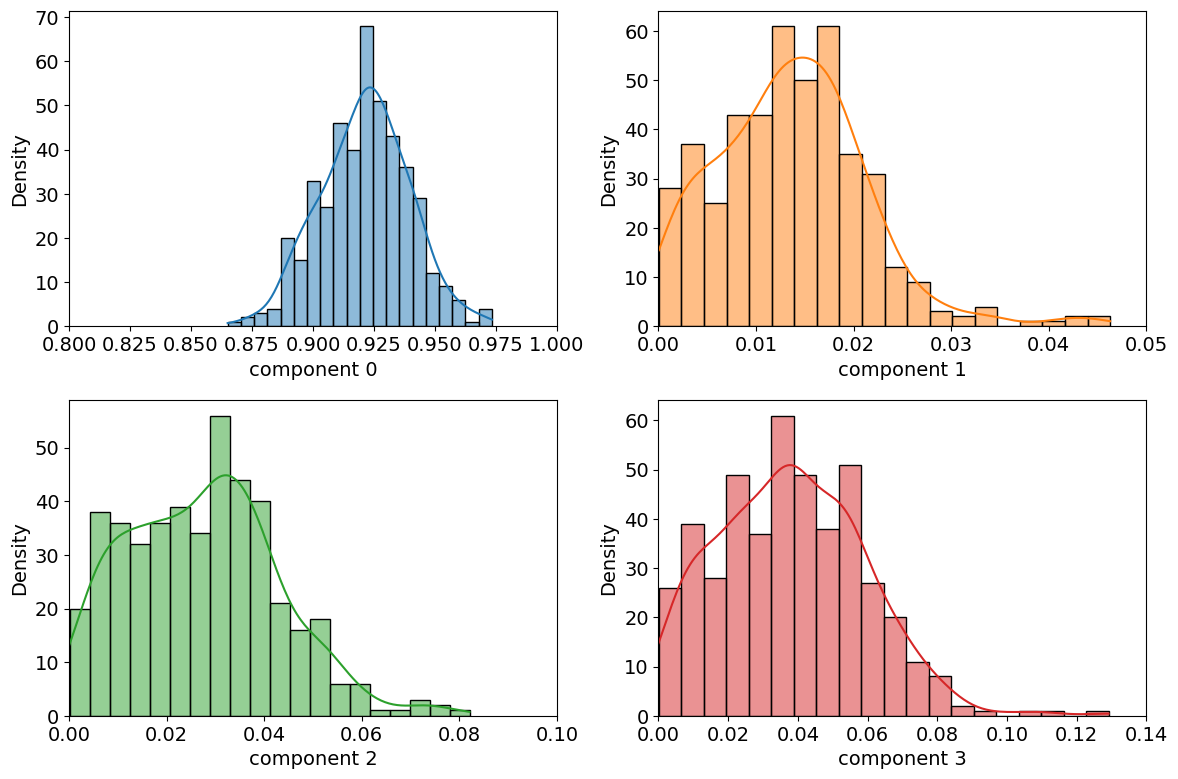

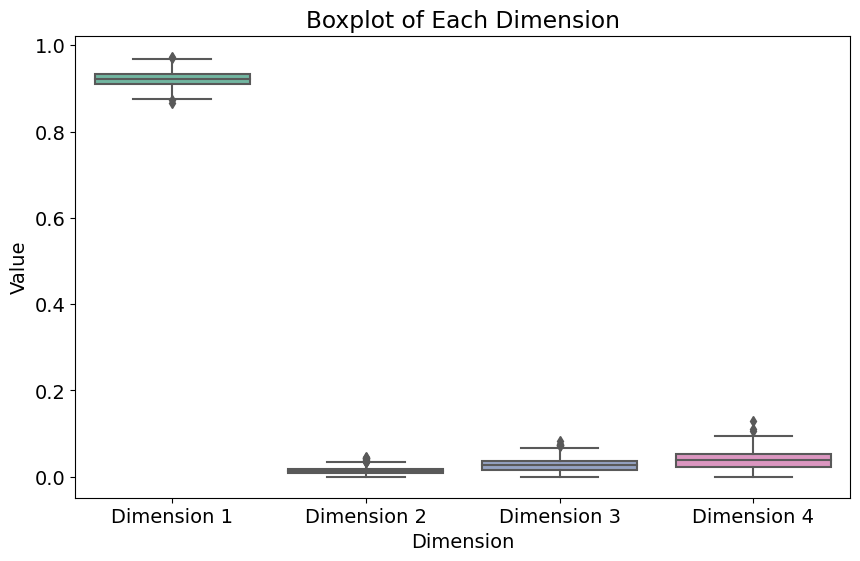

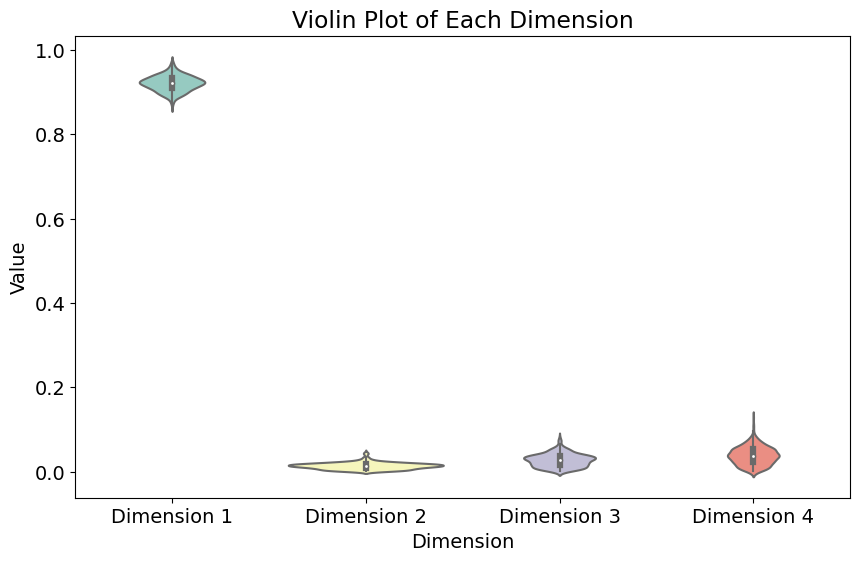

In [8]:
# Combine all samples into a single array (shape: num_seeds * n_samp, n_dim)
combined_samples = all_scaled_samples.reshape(-1, n_dim)

# Plot settings
#sns.set(style="whitegrid")
dim_labels = [f"Dimension {i+1}" for i in range(n_dim)]

# Plot 1: Histograms for each dimension
plt.figure(figsize=(12, 8))
for i in range(n_dim):
    ax = plt.subplot(2, 2, i + 1)
    sns.histplot(combined_samples[:, i], bins=20, kde=True, color=f"C{i}")
    #ax.set_title(f"Histogram of {dim_labels[i]}")
    ax.set_xlabel(f"component {i}")
    ax.set_ylabel("Density")
    if bounds is not None and i < len(bounds):
        ax.set_xlim(bounds[i])  # Correct way to set x-limits for each subplot
plt.tight_layout()
plt.show()


# Plot 2: Boxplot for each dimension
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_samples, palette="Set2")
plt.title("Boxplot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

# Plot 3: Violin Plot for Each Dimension
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_samples, palette="Set3")
plt.title("Violin Plot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

In [9]:
all_val_samples_mdu = mean_samples
all_val_samples_mdu

array([[0.91177145, 0.01256939, 0.02603423, 0.04962493],
       [0.91712657, 0.0150803 , 0.01414787, 0.05364527],
       [0.91904575, 0.00728113, 0.03799002, 0.0356831 ],
       [0.90668967, 0.0113162 , 0.02306259, 0.05893154],
       [0.92078914, 0.01025857, 0.03619963, 0.03275266],
       [0.91277344, 0.01089038, 0.02360198, 0.05273419],
       [0.91828752, 0.01244712, 0.03086516, 0.03840021],
       [0.92363604, 0.01900935, 0.01866026, 0.03869436],
       [0.91361719, 0.01233223, 0.03507676, 0.03897382],
       [0.90353133, 0.01096672, 0.03875834, 0.04674361],
       [0.91632573, 0.01565007, 0.03019732, 0.03782687],
       [0.93060715, 0.01586926, 0.0294879 , 0.02403569],
       [0.93443521, 0.01932334, 0.02795094, 0.01829051],
       [0.93559707, 0.00967244, 0.0211208 , 0.03360969],
       [0.92741539, 0.00984149, 0.02938394, 0.03335918],
       [0.92443235, 0.01917873, 0.02765107, 0.02873786],
       [0.91908025, 0.00962706, 0.03000662, 0.04128608],
       [0.91649803, 0.01093258,

### Import data and format

In [10]:
import csv

filename = '../../../CASTRO/examples/data/Bank_Data-2808_mod_corrected.csv'
df = pd.read_csv(filename, sep=';', decimal=",")
#df = df.replace(',','.', regex=True)
df = df.div(100.)
print(df, len(df))
data_array = np.zeros((len(df),dim))
data_array = np.column_stack((df['PA-56'].to_numpy(), df['PhA'], df['am-based'], df['met-based']))


    PA-56    HNT    PhA   CS   BN   THAM   CaBO   ZnBO    Mel  met-based   
0    1.00  0.000  0.000  0.0  0.0  0.000  0.000  0.000  0.000      0.000  \
1    1.00  0.000  0.000  0.0  0.0  0.000  0.000  0.000  0.000      0.000   
2    0.95  0.000  0.017  0.0  0.0  0.033  0.000  0.000  0.000      0.000   
3    0.95  0.000  0.017  0.0  0.0  0.017  0.000  0.017  0.000      0.017   
4    0.95  0.000  0.017  0.0  0.0  0.017  0.017  0.000  0.000      0.017   
..    ...    ...    ...  ...  ...    ...    ...    ...    ...        ...   
70   0.90  0.050  0.000  0.0  0.0  0.000  0.000  0.000  0.050      0.050   
71   0.97  0.020  0.000  0.0  0.0  0.000  0.000  0.000  0.010      0.020   
72   0.95  0.033  0.000  0.0  0.0  0.000  0.000  0.000  0.017      0.033   
73   0.93  0.047  0.000  0.0  0.0  0.000  0.000  0.000  0.023      0.047   
74   0.90  0.067  0.000  0.0  0.0  0.000  0.000  0.000  0.033      0.067   

    am-based  
0      0.000  
1      0.000  
2      0.033  
3      0.017  
4      0.017

#### Standardize data

In [11]:
scaler = StandardScaler().fit(data_array)
data_scaled = scaler.transform(data_array)
scaler2 = StandardScaler().fit(all_val_samples)
all_val_samples_scaled = scaler2.transform(all_val_samples)
scaler3 = StandardScaler().fit(all_val_samples_mdu)
all_val_samples_mdu_scaled = scaler3.transform(all_val_samples_mdu)

### Transform with PCA and plot first two dimensions which are the most informative ones, for both LHS samples and Data

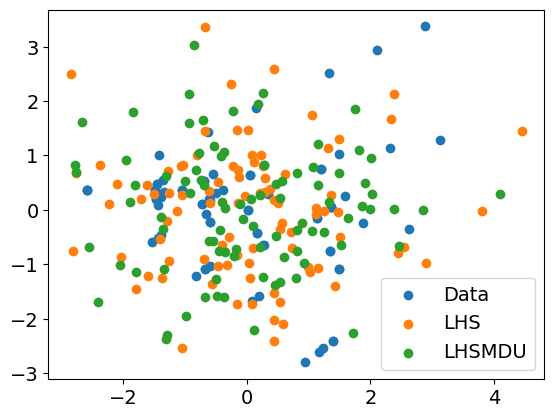

[-1.70821931 -0.14414892  2.37722146  1.36242171 -0.15224539  3.80319223
 -0.283327    0.43442535 -0.69031424  0.43593984 -1.26074138  0.08308302
 -2.37107717  0.99480821  0.62673137 -0.8092556  -1.78837374 -0.46649414
 -0.45792098  1.32265632 -0.31354647 -1.27921825  1.11933984 -1.39690812
 -1.59850615 -1.02362103  0.29910514  0.44737031 -0.12153882  0.05261236
 -0.22063419  1.50451808  0.71662005  4.44925715 -0.59468578 -2.22033879
 -0.15906429  1.49817298 -0.40593527 -0.66675774 -0.1569369  -2.03874409
  1.43240826  1.47104482  0.54127717  2.53777368 -0.13297317 -1.25490639
  0.44814982  2.89767137  0.59496568  0.10412815  0.21365609  0.12653038
 -1.37414667 -0.60362885 -1.03760864  0.08038719 -1.49384886  0.2633412
  1.0481891   1.14750518 -2.80172719 -1.05601045  0.22498061  0.29932579
 -0.2605454  -1.61076857 -0.55908423  0.44142587 -2.09193506  0.53660556
  0.01904929 -1.12034989  2.32970362  1.11481496  0.50246623 -2.76071365
 -0.03046507  2.4525217  -2.83875423  0.73755948  1.

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xt1 = pca.fit_transform(data_scaled)
Xt2 = pca.fit_transform(all_val_samples_scaled)
Xt3 = pca.fit_transform(all_val_samples_mdu_scaled)
#y = np.zeros((1,n_samp*4))
#y[0,0:n_samp] = 0
#y[0,n_samp:n_samp*2] = 1
#y[0,n_samp*2:n_samp*3] = 2
#y[0,n_samp*3:n_samp*4] = 3
# y = np.zeros((1, dim))
# y[0,0] = (0.8+1)/2
# y[0,1] = 0.2/2
# y[0,2] = 0.2/2
# y[0,3] = 0.2/2
# print(y)
plt.scatter(Xt1[:,0], Xt1[:,1])
#plt.legend(handles=plot.legend_elements()[0])#, labels=['PA56', 'PhA', 'am-based', 'met-based'])
plt.scatter(Xt2[:,0], Xt2[:,1])
plt.scatter(Xt3[:,0], Xt3[:,1])
plt.legend(['Data', 'LHS', 'LHSMDU'])
plt.show()
print(Xt2[:,0],Xt2[:,1])



In [13]:
print(len(Xt2), len(Xt3))

90 90


In [14]:
#print(len(Xt1))
for i in range(len(Xt2)):
    if (Xt2[i,1]>-0.06 and Xt2[i,1]<-0.04 and Xt2[i,0]< -0.1):
        print(Xt2[i,0],Xt2[i,1],Xt2[i,:],i)
        print('orig',all_val_samples[i,:])

In [15]:
# X_LHS_orig = pca.inverse_transform(pca.fit_transform(Xt1))
# print(X_LHS_orig[13,:])
# print(X_LHS_orig[18,:])

### Transform with PCA and plot first two dimensions which are the most informative ones, for both LHS samples and Data

In [16]:
# #from sklearn.decomposition import PCA
# pca = PCA()
# Xt1 = pca.fit_transform(data_array)
# Xt2 = pca.fit_transform(all_val_samples)
# Xt3 = pca.fit_transform(all_val_samples_mdu)
# #y = np.zeros((1,n_samp*4))
# #y[0,0:n_samp] = 0
# #y[0,n_samp:n_samp*2] = 1
# #y[0,n_samp*2:n_samp*3] = 2
# #y[0,n_samp*3:n_samp*4] = 3
# # y = np.zeros((1, dim))
# # y[0,0] = (0.8+1)/2
# # y[0,1] = 0.2/2
# # y[0,2] = 0.2/2
# # y[0,3] = 0.2/2
# # print(y)
# tol = 2e-2
# #print(type(Xt1))

# df = pd.DataFrame(Xt2)
# for i in range(len(Xt1)):
#     for j in range(len(Xt2)):
#         #Xt2 = np.delete(Xt2, np.where(abs(Xt1[i,0]-Xt2[j,0])<tol and abs(Xt1[i,1]-Xt2[j,1])<tol))
#         if (abs(Xt1[i,0]-Xt2[j,0])<tol and abs(Xt1[i,1]-Xt2[j,1])<tol):
#             df.iloc[j,0]=np.nan
#             df.iloc[j,1]=np.nan
# df = df.dropna()
# Xt2_new = df.to_numpy()
# df2 = pd.DataFrame(Xt3)           
# for i in range(len(Xt1)):
#         for j in range(len(Xt3)):
#             if (abs(Xt1[i,0]-Xt3[j,0])<tol and abs(Xt1[i,1]-Xt3[j,1])<tol):
#                 df2.iloc[j,0]=np.nan
#                 df2.iloc[j,1]=np.nan
# df2 = df2.dropna()
# Xt3_new = df2.to_numpy()    
# plt.scatter(Xt1[:,0], Xt1[:,1])
# #plt.legend(handles=plot.legend_elements()[0])#, labels=['PA56', 'PhA', 'am-based', 'met-based'])
# plt.scatter(Xt2_new[:,0], Xt2_new[:,1])
# plt.scatter(Xt3_new[:,0], Xt3_new[:,1])
# plt.legend(['Data', 'LHS', 'LHSMDU'])
# plt.show()
# #print(Xt2[:,0],Xt2[:,1])



In [17]:
# print(len(Xt2_new), len(Xt3_new))

#### Select subset of samples that varies the most in terms of distance from the already collected data

In [18]:
tol = 1e-5
tol2 = 1e-5
des_n_samp = 90

tol_samples, tol_samples_LHSMDU, tol_samples_unscaled, tol_samples_LHSMDU_unscaled = select_samples_diff_from_data(exp_data=data_array, samples_LHS=all_val_samples, samples_LHSMDU=all_val_samples_mdu, des_n_samp = des_n_samp, tol = tol, tol2 = tol2)


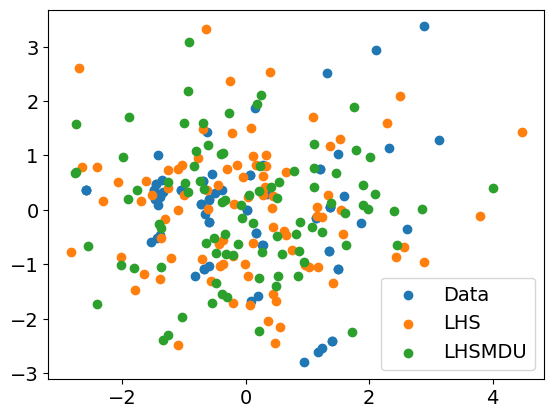

In [19]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
lhs_samples_pca = pca.fit_transform(tol_samples)
lhsmdu_samples_pca = pca.fit_transform(tol_samples_LHSMDU)

plot_dimred_2dims_both_methods(data_pca, lhs_samples_pca, lhsmdu_samples_pca)

#### Test whether all selected samples are feasible

In [20]:
for i in range(len(tol_samples_unscaled)):
    for j in range(dim):
        if tol_samples_unscaled[i,j]<bounds[j][0] or tol_samples_unscaled[i,j]>bounds[j][1]:
            print("not feasible", tol_samples_unscaled[i,:])
print("-------------------")
for i in range(len(tol_samples_LHSMDU_unscaled)):
    for j in range(dim):
        if tol_samples_LHSMDU_unscaled[i,j]<bounds[j][0] or tol_samples_LHSMDU_unscaled[i,j]>bounds[j][1]:
            print("not feasible", tol_samples_LHSMDU_unscaled[i,:])

-------------------


In [21]:
tol = 5e-1
tol2 = 5e-1
des_n_samp = 15

tol_samples_15, tol_samples_LHSMDU_15, tol_samples_unscaled_15, tol_samples_LHSMDU_unscaled_15 = select_samples_diff_from_data(exp_data=data_array, samples_LHS=tol_samples, samples_LHSMDU=tol_samples_LHSMDU, des_n_samp = des_n_samp, tol = tol, tol2 = tol2)


In [22]:
df_15_samps_scaled = pd.DataFrame(tol_samples,columns=['PA-56','PhA','am-based','met-based'])
df_15_samps = pd.DataFrame(tol_samples_unscaled,columns=['PA-56','PhA','am-based','met-based'])

#### Check if add up to 100%

In [23]:
df_perc = df_15_samps*100
for i in range(len(df_15_samps)):
    if abs(df_15_samps.iloc[i,:].sum()-1)>1e-4:
        ind_list = np.where(df_15_samps.iloc[i,:]!=0)[0]
        ind = np.random.choice(ind_list)
        df_15_samps.iloc[i,ind] = df_15_samps.iloc[i,ind] - (df_15_samps.iloc[i,:].sum()-1)

In [24]:
df_perc

,PA-56,PhA,am-based,met-based
0,93.1,1.3,2.1,3.5
1,93.1,1.3,2.2,3.4
2,92.5,1.5,2.1,3.9
3,92.7,1.3,2.6,3.4
4,92.4,1.4,2.5,3.6
...,...,...,...,...
85,94.0,1.6,2.2,2.2
86,93.6,1.6,0.9,3.9
87,92.9,2.3,1.1,3.7
88,95.0,1.3,1.0,2.6


### **7. Distribution plots**

#### Distribution subplots of unscaled data

In [25]:
#box_kdeplot_samples(data_array, filename_eps='Figures_4dim/dist_unscaled_expdata.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


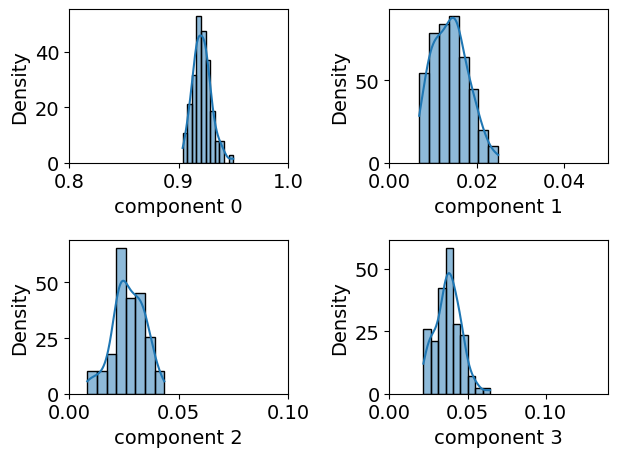

In [26]:
box_kdeplot_samples(all_val_samples, filename_eps='dist_unscaled_90ptsLHS.eps', fixed_ranges=bounds)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


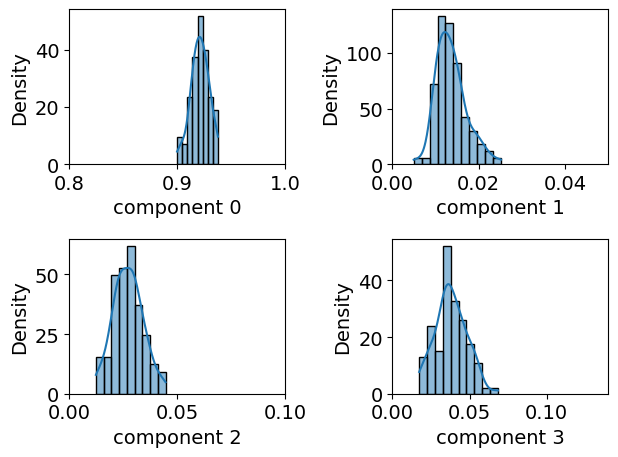

In [27]:
box_kdeplot_samples(all_val_samples_mdu, filename_eps='dist_unscaled_90ptsLHSMDU.eps', fixed_ranges=bounds)

#### Distribution subplots of scaled reduced data

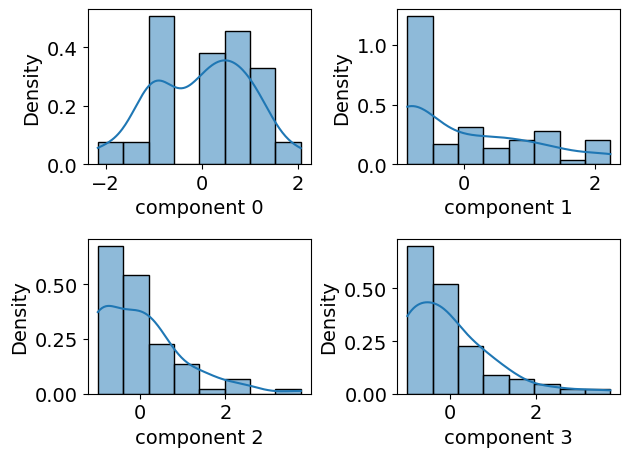

In [28]:
box_kdeplot_samples(data_scaled)

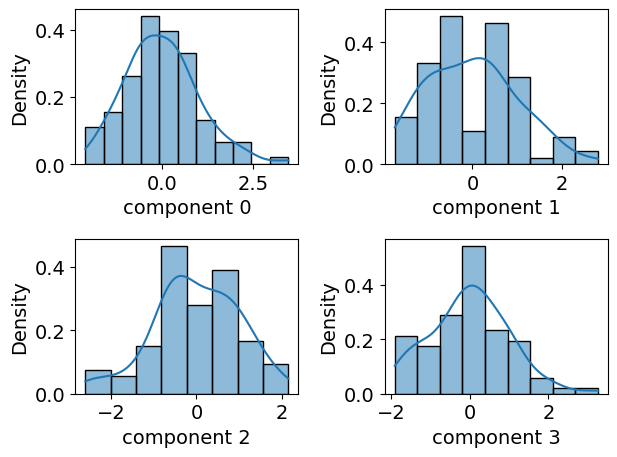

In [29]:
box_kdeplot_samples(tol_samples)


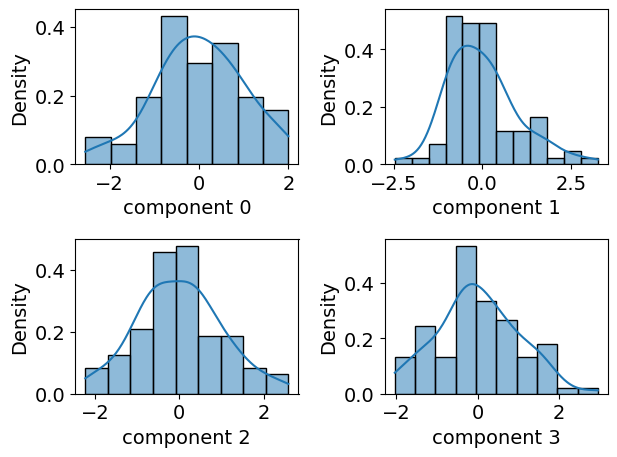

In [30]:
box_kdeplot_samples(tol_samples_LHSMDU)

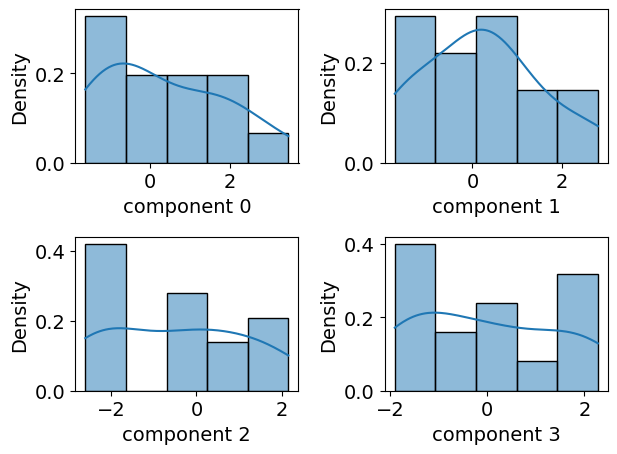

In [31]:
box_kdeplot_samples(tol_samples_unscaled_15)


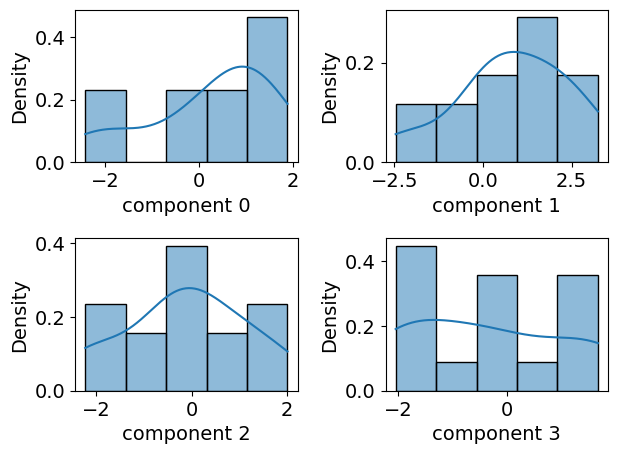

In [32]:
box_kdeplot_samples(tol_samples_LHSMDU_unscaled_15)

### **8. Discrepancy for LHS and LHSMDU with mixture constraint sum=1**

In [33]:
l_bounds = [0.8, 0, 0, 0]
u_bounds = [1., 0.05, 0.1, 0.14]
space = qmc.scale(all_val_samples, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

0.51676222876977

In [34]:
qmc.discrepancy(space, method='WD')


1.1112350461401337

In [35]:
np.linalg.norm(space.var())

0.025229878791062227

In [36]:
space = qmc.scale(all_val_samples_mdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

0.5185360117097926

In [37]:
qmc.discrepancy(space, method='WD')

1.1133355018720175

In [38]:
np.linalg.norm(space.var())

0.02516105103828255

In [39]:
tol_samples_unscaled_15

array([[-1.626, -1.232,  0.386,  1.906],
       [-0.779, -0.222, -0.159,  1.045],
       [-1.263, -1.484,  0.114,  1.906],
       [-1.263,  1.293, -1.795,  2.275],
       [-0.416, -1.737,  1.204,  0.307],
       [ 0.432,  0.031,  1.477, -1.783],
       [ 2.005,  0.536, -0.704, -1.537],
       [-0.295, -1.232,  2.159, -1.045],
       [-1.263,  0.283,  1.613, -0.307],
       [-0.295,  0.283, -1.659,  1.783],
       [ 1.4  ,  1.293, -0.159, -1.906],
       [ 1.763,  0.536, -2.477,  0.184],
       [ 0.916,  2.303, -2.204, -0.061],
       [ 3.458, -0.222, -2.34 , -1.414],
       [ 2.369,  2.808, -2.613, -1.414]])

In [40]:
space = qmc.scale(df_15_samps, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

0.5173060807847689

In [41]:
qmc.discrepancy(space, method='WD')

1.115241170021117

In [42]:
np.linalg.norm(space.var())

0.025184117142227284

In [43]:
df_data = df[['PA-56','PhA','am-based','met-based']].copy()
df_data = df_data
df_with_data = pd.concat([df_15_samps, df_data], ignore_index=True, axis=0)

In [44]:
space = qmc.scale(df_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)#default CD

0.4288280154164683

In [45]:
qmc.discrepancy(space, method='WD')

0.5358568324540944

In [46]:
np.linalg.norm(space.var())

0.05490674814471243

In [47]:
df_15_samps_mdu = pd.DataFrame(tol_samples_LHSMDU_unscaled,columns=['PA-56','PhA','am-based','met-based'])
df_15_samps_mdu_scaled = pd.DataFrame(tol_samples_LHSMDU,columns=['PA-56','PhA','am-based','met-based'])
space = qmc.scale(df_15_samps_mdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

0.5181592216399826

In [48]:
qmc.discrepancy(space, method='WD')

1.1133985303129372

In [49]:
np.linalg.norm(space.var())

0.0251667882298753

In [50]:
df_lhsmdu_with_data = pd.concat([df_15_samps_mdu, df_data], ignore_index=True, axis=0)

In [51]:
space = qmc.scale(df_lhsmdu_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)#default CD

0.4292789871067062

In [52]:
qmc.discrepancy(space, method='WD')

0.5352062476530146

In [53]:
np.linalg.norm(space.var())

0.05489153231175391